# Overview

This notebook contains my solutions for **<a href="https://adventofcode.com/2017" target="_blank">Advent of Code 2017</a>**.

A few notes...
- The source for this notebook source lives in my GitHub repo, <a href="https://github.com/derailed-dash/Advent-of-Code/blob/master/src/AoC_2017/Dazbo's_Advent_of_Code_2017.ipynb" target="_blank">here</a>.
- You can run this Notebook wherever you like. For example, you could...
  - Run it locally, in your own Jupyter environment.
  - Run it in a cloud-based Jupyter environment, with no setup required on your part!  For example, <a href="https://colab.research.google.com/github/derailed-dash/Advent-of-Code/blob/master/src/AoC_2017/Dazbo's_Advent_of_Code_2017.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab"/></a>
- **To run the notebook, execute the cells in the [Setup](#Setup) section, as described below. Then you can run the code for any given day.**
- Be mindful that the first time you run this notebook, you will need to **obtain your AoC session key** and store it, if you have not done so already. This allows the notebook to automatically retrieve your input data. (See the guidance in the **[Get Access to Your AoC Data](#Get-Access-to-Your-AoC-Data)** section for details.)
- Use the navigation menu on the left to jump to any particular day.
- All of my AoC solutions are documented in my <a href="https://aoc.just2good.co.uk/" target="_blank">AoC Python Walkthrough site</a>.

# Setup

You need to run all cells in this section, before running any particular day solution.

## Packages and Imports

Here we use `pip` to install the packages used by my solutions in this event.

In [37]:
%pip install jupyterlab-lsp colorama python-dotenv ipykernel 

In [147]:
from __future__ import annotations
import copy
from dataclasses import asdict, dataclass, field
from enum import Enum
from functools import cache
from itertools import permutations, combinations, count
import operator
import logging
import time
import os
import re
import unittest
import requests
import numpy as np
from dotenv import load_dotenv
from pathlib import Path
from getpass import getpass
from colorama import Fore
from collections import Counter, deque, defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

## Logging and Output

Set up a new logger that uses `ColouredFormatter`, such that we have coloured logging.  The log colour depends on the logging level.

In [4]:
##########################################################################
# SETUP LOGGING
#
# Create a new instance of "logger" in the client application
# Set to your preferred logging level
# And add the stream_handler from this module, if you want coloured output
##########################################################################

# logger for aoc_commons only
logger = logging.getLogger(__name__) # aoc_common.aoc_commons
logger.setLevel(logging.INFO)
stream_handler = None

class ColouredFormatter(logging.Formatter):
    """ Custom Formater which adds colour to output, based on logging level """

    level_mapping = {"DEBUG": (Fore.BLUE, "DBG"),
                     "INFO": (Fore.GREEN, "INF"),
                     "WARNING": (Fore.YELLOW, "WRN"),
                     "ERROR": (Fore.RED, "ERR"),
                     "CRITICAL": (Fore.MAGENTA, "CRT")
    }

    def __init__(self, *args, apply_colour=True, shorten_lvl=True, **kwargs) -> None:
        """ Args:
            apply_colour (bool, optional): Apply colouring to messages. Defaults to True.
            shorten_lvl (bool, optional): Shorten level names to 3 chars. Defaults to True.
        """
        super().__init__(*args, **kwargs)
        self._apply_colour = apply_colour
        self._shorten_lvl = shorten_lvl

    def format(self, record):
        if record.levelname in ColouredFormatter.level_mapping:
            new_rec = copy.copy(record)
            colour, new_level = ColouredFormatter.level_mapping[record.levelname]

            if self._shorten_lvl:
                new_rec.levelname = new_level

            if self._apply_colour:
                msg = colour + super().format(new_rec) + Fore.RESET
            else:
                msg = super().format(new_rec)

            return msg

        # If our logging message is not using one of these levels...
        return super().format(record)

if not stream_handler:
    stream_handler = logging.StreamHandler()
    stream_fmt = ColouredFormatter(fmt='%(asctime)s.%(msecs)03d:%(name)s - %(levelname)s: %(message)s',
                                   datefmt='%H:%M:%S')
    stream_handler.setFormatter(stream_fmt)
    
if not logger.handlers:
    # Add our ColouredFormatter as the default console logging
    logger.addHandler(stream_handler)

def retrieve_console_logger(script_name):
    """ Create and return a new logger, named after the script
    So, in your calling code, add a line like this:
    logger = ac.retrieve_console_logger(locations.script_name)
    """
    a_logger = logging.getLogger(script_name)
    a_logger.addHandler(stream_handler)
    a_logger.propagate = False
    return a_logger

def setup_file_logging(a_logger: logging.Logger, folder: str|Path=""):
    """ Add a FileHandler to the specified logger. File name is based on the logger name.
    In calling code, we can add a line like this:
    td.setup_file_logging(logger, locations.output_dir)

    Args:
        a_logger (Logger): The existing logger
        folder (str): Where the log file will be created. Will be created if it doesn't exist
    """
    Path(folder).mkdir(parents=True, exist_ok=True)     # Create directory if it does not exist
    file_handler = logging.FileHandler(Path(folder, a_logger.name + ".log"), mode='w')
    file_fmt = logging.Formatter(fmt="%(asctime)s.%(msecs)03d:%(name)s:%(levelname)8s: %(message)s",
                                datefmt='%H:%M:%S')
    file_handler.setFormatter(file_fmt)
    a_logger.addHandler(file_handler)

In [5]:
def top_and_tail(data, block_size=5, include_line_numbers=True, zero_indexed=False):
    """ Print a summary of a large amount of data 

    Args:
        data (_type_): The data to present in summary form.
        block_size (int, optional): How many rows to include in the top, and in the tail.
        include_line_numbers (bool, optional): Prefix with line number. Defaults to True.
        zero_indexed (bool, optional): Lines start at 0? Defaults to False.
    """
    if isinstance(data, list):
        # Get the number of digits of the last item for proper alignment
        num_digits_last_item = len(str(len(data)))

        # Format the string with line number
        def format_with_line_number(idx, line):
            start = 0 if zero_indexed else 1
            if include_line_numbers:
                return f"{idx + start:>{num_digits_last_item}}: {line}"
            else:
                return line

        start = 0 if zero_indexed else 1
        if len(data) < 11:
            return "\n".join(format_with_line_number(i, line) for i, line in enumerate(data))
        else:
            top = [format_with_line_number(i, line) for i, line in enumerate(data[:block_size])]
            tail = [format_with_line_number(i, line) for i, line in enumerate(data[-block_size:], start=len(data)-block_size)]
            return "\n".join(top + ["..."] + tail)
    else:
        return data

## Get Access to Your AoC Data

Now provide your unique AoC session key, in order to download your input data. You can get this by:
1. Logging into [Advent of Code](https://adventofcode.com/).
1. From your browser, open Developer Tools. (In Chrome, you can do this by pressing F12.)
1. Open the `Application` tab.
1. Storage -> Cookies -> https://adventofcode.com
1. Copy the value associated with the cookie called `session`.
1. Once you've determiend your session key, I recommend you store it in a file called `.env`, in your `Advent-of-Code` folder, like this: \
`AOC_SESSION_COOKIE=536...your-own-session-key...658` \
This notebook will try to retrieve the key from that location.  If it is unable to retrieve the key, it will prompt you to enter your key in the cell below.

![Finding the session cookie](https://aoc.just2good.co.uk/assets/images/aoc-cookie.png)



In [6]:
def get_envs_from_file() -> bool:
    """ Look for .env files, read variables from it, and store as environment variables """
    potential_path = ".env"
    for _ in range(3):
        logger.debug("Trying .env at %s", os.path.realpath(potential_path))
        if os.path.exists(potential_path):
            logger.info("Using .env at %s", os.path.realpath(potential_path))
            load_dotenv(potential_path, verbose=True)
            return True
        
        potential_path = os.path.join('..', potential_path)
   
    logger.warning("No .env file found.")
    return False

get_envs_from_file() # read env variables from a .env file, if we can find one

16:32:24.601:__main__ - INF: Using .env at C:\Users\djl\localdev\Python\Advent-of-Code\.env


True

In [7]:
if os.getenv('AOC_SESSION_COOKIE'):
    logger.info('Session cookie retrieved: %s...%s', os.environ['AOC_SESSION_COOKIE'][0:6], os.environ['AOC_SESSION_COOKIE'][-6:])
else: # it's not in our environment variables, so we'll need to input the value
    os.environ['AOC_SESSION_COOKIE'] = getpass('Enter AoC session key: ')

16:32:24.615:__main__ - INF: Session cookie retrieved: 53616c...598658


## Load Helpers and Useful Classes

Now we load a bunch of helper functions and classes.

In [8]:
##########################################################################
# SETUP LOGGING
#
# Create a new instance of "logger" in the client application
# Set to your preferred logging level
# And add the stream_handler from this module, if you want coloured output
##########################################################################

# logger for aoc_commons only
logger = logging.getLogger(__name__) # aoc_common.aoc_commons
logger.setLevel(logging.INFO)
stream_handler = None

class ColouredFormatter(logging.Formatter):
    """ Custom Formater which adds colour to output, based on logging level """

    level_mapping = {"DEBUG": (Fore.BLUE, "DBG"),
                     "INFO": (Fore.GREEN, "INF"),
                     "WARNING": (Fore.YELLOW, "WRN"),
                     "ERROR": (Fore.RED, "ERR"),
                     "CRITICAL": (Fore.MAGENTA, "CRT")
    }

    def __init__(self, *args, apply_colour=True, shorten_lvl=True, **kwargs) -> None:
        """ Args:
            apply_colour (bool, optional): Apply colouring to messages. Defaults to True.
            shorten_lvl (bool, optional): Shorten level names to 3 chars. Defaults to True.
        """
        super().__init__(*args, **kwargs)
        self._apply_colour = apply_colour
        self._shorten_lvl = shorten_lvl

    def format(self, record):
        if record.levelname in ColouredFormatter.level_mapping:
            new_rec = copy.copy(record)
            colour, new_level = ColouredFormatter.level_mapping[record.levelname]

            if self._shorten_lvl:
                new_rec.levelname = new_level

            if self._apply_colour:
                msg = colour + super().format(new_rec) + Fore.RESET
            else:
                msg = super().format(new_rec)

            return msg

        # If our logging message is not using one of these levels...
        return super().format(record)

if not stream_handler:
    stream_handler = logging.StreamHandler()
    stream_fmt = ColouredFormatter(fmt='%(asctime)s.%(msecs)03d:%(name)s - %(levelname)s: %(message)s',
                                   datefmt='%H:%M:%S')
    stream_handler.setFormatter(stream_fmt)
    
if not logger.handlers:
    # Add our ColouredFormatter as the default console logging
    logger.addHandler(stream_handler)

def retrieve_console_logger(script_name):
    """ Create and return a new logger, named after the script
    So, in your calling code, add a line like this:
    logger = ac.retrieve_console_logger(locations.script_name)
    """
    a_logger = logging.getLogger(script_name)
    a_logger.addHandler(stream_handler)
    a_logger.propagate = False
    return a_logger

def setup_file_logging(a_logger: logging.Logger, folder: str|Path=""):
    """ Add a FileHandler to the specified logger. File name is based on the logger name.
    In calling code, we can add a line like this:
    td.setup_file_logging(logger, locations.output_dir)

    Args:
        a_logger (Logger): The existing logger
        folder (str): Where the log file will be created. Will be created if it doesn't exist
    """
    Path(folder).mkdir(parents=True, exist_ok=True)     # Create directory if it does not exist
    file_handler = logging.FileHandler(Path(folder, a_logger.name + ".log"), mode='w')
    file_fmt = logging.Formatter(fmt="%(asctime)s.%(msecs)03d:%(name)s:%(levelname)8s: %(message)s",
                                datefmt='%H:%M:%S')
    file_handler.setFormatter(file_fmt)
    a_logger.addHandler(file_handler)

### Locations

Where any input and output files get stored.

<img src="https://aoc.just2good.co.uk/assets/images/notebook-content-screenshot.png" width="320" />


In [9]:
#################################################################
# Paths and Locations
#################################################################

@dataclass
class Locations:
    """ Dataclass for storing various location properties """
    script_name: str
    script_dir: Path
    input_dir: Path
    output_dir: Path
    input_file: Path

def get_locations(script_name, folder="") -> Locations:
    """ Set various paths, based on the location of the calling script. """
    current_directory = os.getcwd()
    script_dir = Path(Path().resolve(), folder, script_name)
    input_dir = Path(script_dir, "input")
    output_dir = Path(script_dir, "output")
    input_file = Path(input_dir, "input.txt")

    return Locations(script_name, script_dir,
                     input_dir,
                     output_dir,
                     input_file)

### Retrieve the Input Data

This works by using your unique session cookie to retrieve your input data. E.g. from a URL like:

`https://adventofcode.com/2015/day/1/input`

In [10]:
##################################################################
# Retrieving input data
##################################################################

def write_puzzle_input_file(year: int, day, locations: Locations):
    """ Use session key to obtain user's unique data for this year and day.
    Only retrieve if the input file does not already exist.
    Return True if successful.
    Requires env: AOC_SESSION_COOKIE, which can be set from the .env.
    """
    if os.path.exists(locations.input_file):
        logger.debug("%s already exists", os.path.basename(locations.input_file))
        return os.path.basename(locations.input_file)

    session_cookie = os.getenv('AOC_SESSION_COOKIE')
    if not session_cookie:
        raise ValueError("Could not retrieve session cookie.")

    logger.info('Session cookie retrieved: %s...%s', session_cookie[0:6], session_cookie[-6:])

    # Create input folder, if it doesn't exist
    if not locations.input_dir.exists():
        locations.input_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://adventofcode.com/{year}/day/{day}/input"
    cookies = {"session": session_cookie}
    response = requests.get(url, cookies=cookies, timeout=5)

    data = ""
    if response.status_code == 200:
        data = response.text

        with open(locations.input_file, 'w') as file:
            logger.debug("Writing input file %s", os.path.basename(locations.input_file))
            file.write(data)
            return data
    else:
        raise ValueError(f"Unable to retrieve input data. HTTP response: {response.status_code}")


### Testing

A really simple function for testing that our solution produces the expected test output.

In [11]:
def validate(test, answer):
    """
    Args:
        test: the answer given by our solution
        answer: the expected answer, e.g. from instructions
    """
    if test != answer:
        raise AssertionError(f"{test} != {answer}")

### Useful Helper Classes

In [12]:
#################################################################
# POINTS, VECTORS AND GRIDS
#################################################################

@dataclass(frozen=True)
class Point:
    """ Class for storing a point x,y coordinate """
    x: int
    y: int

    def __add__(self, other: Point):
        return Point(self.x + other.x, self.y + other.y)

    def __mul__(self, other: Point):
        """ (x, y) * (a, b) = (xa, yb) """
        return Point(self.x * other.x, self.y * other.y)

    def __sub__(self, other: Point):
        return self + Point(-other.x, -other.y)

    def yield_neighbours(self, include_diagonals=True, include_self=False):
        """ Generator to yield neighbouring Points """

        deltas: list
        if not include_diagonals:
            deltas = [vector.value for vector in Vectors if abs(vector.value[0]) != abs(vector.value[1])]
        else:
            deltas = [vector.value for vector in Vectors]

        if include_self:
            deltas.append((0, 0))

        for delta in deltas:
            yield Point(self.x + delta[0], self.y + delta[1])

    def neighbours(self, include_diagonals=True, include_self=False) -> list[Point]:
        """ Return all the neighbours, with specified constraints.
        It wraps the generator with a list. """
        return list(self.yield_neighbours(include_diagonals, include_self))

    def get_specific_neighbours(self, directions: list[Vectors]) -> list[Point]:
        """ Get neighbours, given a specific list of allowed locations """
        return [(self + Point(*vector.value)) for vector in list(directions)]

    @staticmethod
    def manhattan_distance(a_point: Point) -> int:
        """ Return the Manhattan distance value of this vector """
        return sum(abs(coord) for coord in asdict(a_point).values())

    def manhattan_distance_from(self, other: Point) -> int:
        """ Manhattan distance between this Vector and another Vector """
        diff = self-other
        return Point.manhattan_distance(diff)

    def __repr__(self):
        return f"P({self.x},{self.y})"

class Vectors(Enum):
    """ Enumeration of 8 directions.
    Note: y axis increments in the North direction, i.e. N = (0, 1) """
    N = (0, 1)
    NE = (1, 1)
    E = (1, 0)
    SE = (1, -1)
    S = (0, -1)
    SW = (-1, -1)
    W = (-1, 0)
    NW = (-1, 1)

    @property
    def y_inverted(self):
        """ Return vector, but with y-axis inverted. I.e. N = (0, -1) """
        x, y = self.value
        return (x, -y)

class VectorDicts():
    """ Contains constants for Vectors """
    ARROWS = {
        '^': Vectors.N.value,
        '>': Vectors.E.value,
        'v': Vectors.S.value,
        '<': Vectors.W.value
    }

    DIRS = {
        'U': Vectors.N.value,
        'R': Vectors.E.value,
        'D': Vectors.S.value,
        'L': Vectors.W.value
    }

    NINE_BOX: dict[str, tuple[int, int]] = {
        # x, y vector for adjacent locations
        'tr': (1, 1),
        'mr': (1, 0),
        'br': (1, -1),
        'bm': (0, -1),
        'bl': (-1, -1),
        'ml': (-1, 0),
        'tl': (-1, 1),
        'tm': (0, 1)
    }

class Grid():
    """ 2D grid of point values. """
    def __init__(self, grid_array: list) -> None:
        self._array = grid_array
        self._width = len(self._array[0])
        self._height = len(self._array)

    def value_at_point(self, point: Point) -> int:
        """ The value at this point """
        return self._array[point.y][point.x]

    def set_value_at_point(self, point: Point, value: int):
        self._array[point.y][point.x] = value

    def valid_location(self, point: Point) -> bool:
        """ Check if a location is within the grid """
        if (0 <= point.x < self._width and  0 <= point.y < self._height):
            return True

        return False

    @property
    def width(self):
        """ Array width (cols) """
        return self._width

    @property
    def height(self):
        """ Array height (rows) """
        return self._height

    def all_points(self) -> list[Point]:
        points = [Point(x, y) for x in range(self.width) for y in range(self.height)]
        return points

    def rows_as_str(self):
        """ Return the grid """
        return ["".join(str(char) for char in row) for row in self._array]

    def cols_as_str(self):
        """ Render columns as str. Returns: list of str """
        cols_list = list(zip(*self._array))
        return ["".join(str(char) for char in col) for col in cols_list]

    def __repr__(self) -> str:
        return f"Grid(size={self.width}*{self.height})"

    def __str__(self) -> str:
        return "\n".join("".join(map(str, row)) for row in self._array)

### Useful Helper Functions

In [13]:
#################################################################
# CONSOLE STUFF
#################################################################

def cls():
    """ Clear console """
    os.system('cls' if os.name=='nt' else 'clear')

#################################################################
# USEFUL FUNCTIONS
#################################################################

def binary_search(target, low:int, high:int, func, *func_args, reverse_search=False):
    """ Generic binary search function that takes a target to find,
    low and high values to start with, and a function to run, plus its args.
    Implicitly returns None if the search is exceeded. """

    res = None  # just set it to something that isn't the target
    candidate = 0  # initialise; we'll set it to the mid point in a second

    while low < high:  # search exceeded
        candidate = int((low+high) // 2)  # pick mid-point of our low and high
        res = func(candidate, *func_args) # run our function, whatever it is
        logger.debug("%d -> %d", candidate, res)
        if res == target:
            return candidate  # solution found

        comp = operator.lt if not reverse_search else operator.gt
        if comp(res, target):
            low = candidate
        else:
            high = candidate

def merge_intervals(intervals: list[list]) -> list[list]:
    """ Takes intervals in the form [[a, b][c, d][d, e]...]
    Intervals can overlap.  Compresses to minimum number of non-overlapping intervals. """
    intervals.sort()
    stack = []
    stack.append(intervals[0])

    for interval in intervals[1:]:
        # Check for overlapping interval
        if stack[-1][0] <= interval[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], interval[-1])
        else:
            stack.append(interval)

    return stack

@cache
def get_factors(num: int) -> set[int]:
    """ Gets the factors for a given number. Returns a set[int] of factors.
        # E.g. when num=8, factors will be 1, 2, 4, 8 """
    factors = set()

    # Iterate from 1 to sqrt of 8,
    # since a larger factor of num must be a multiple of a smaller factor already checked
    for i in range(1, int(num**0.5) + 1):  # e.g. with num=8, this is range(1, 3)
        if num % i == 0: # if it is a factor, then dividing num by it will yield no remainder
            factors.add(i)  # e.g. 1, 2
            factors.add(num//i)  # i.e. 8//1 = 8, 8//2 = 4

    return factors

def to_base_n(number: int, base: int):
    """ Convert any integer number into a base-n string representation of that number.
    E.g. to_base_n(38, 5) = 123

    Args:
        number (int): The number to convert
        base (int): The base to apply

    Returns:
        [str]: The string representation of the number
    """
    ret_str = ""
    curr_num = number
    while curr_num:
        ret_str = str(curr_num % base) + ret_str
        curr_num //= base

    return ret_str if number > 0 else "0"


### Generic Initialisation


In [14]:
FOLDER = "aoc"
YEAR = 2017
logger_identifier = "aoc" + str(YEAR)
logger = retrieve_console_logger(logger_identifier)
logger.setLevel(logging.DEBUG)

# Days

Here you'll find a template to build a solution for a given day, and then the solutions for all days in this event.

To copy the template day, select all the cells in the `Day n` template, add a new cell at the end, and then paste the cells there.

## Day n: title

In [ ]:
DAY = "n" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.info("Input data:\n%s", top_and_tail(input_data))

### Day n Part 1

Overview...

In [ ]:
def solve(data):
    pass

In [ ]:
%%time
validate(solve("abcdef"), "uvwxyz") # test with sample data
soln = solve(input_data)
logger.info(f"Part 1 soln={soln}")

### Day n Part 2

Overview...

In [ ]:
def solve(data):
    pass

In [ ]:
%%time
validate(solve("abcdef"), "uvwxyz") # test with sample data
soln = solve(input_data)
logger.info(f"Part 2 soln={soln}")

## Day 1: Inverse Captcha

In [ ]:
DAY = 1
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().strip()

logger.info("Input data:\n%s", top_and_tail(input_data))

### Day 1 Part 1

The time is 25ms to midnight, and we're inside the computer that prints the _Naughty or Nice_ list! Each day in this year's challenge brings us 1ms closer to midnight.

Today, we have to solve a Captcha to prove that we're _not_ human.

Sum all digits that match the next digit in a circular list.

In [ ]:
def sum_match_digits(data, offset: int) -> int:
    circular_digits = data + data
    logger.debug(circular_digits)
    total = 0
    for i in range(len(data)):
        if circular_digits[i] == circular_digits[i+offset]:
            total += int(circular_digits[i])

    return total

In [ ]:
def part1(data) -> int:
    return sum_match_digits(data, 1)

In [ ]:
%%time
validate(part1("91212129"), 9) # test with sample data
soln = part1(input_data)
logger.info("Part 1: total=%d", soln)
# logger.info("Execution time: %.3f seconds", t2 - t1)

### Day 1 Part 2

Sum all the digits that match a digit that is exactly halfway along.

In [ ]:
def part2(data) -> int:
    half = len(data)//2
    logger.debug("Half=%s", half)
    return sum_match_digits(data, half)

In [ ]:
%%time
validate(part2("12131415"), 4)
soln = part2(input_data)
logger.info("Part 2: total=%d", soln)

## Day 2: Corruption Checksum

In [ ]:
DAY = 2
day_link = f"See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.info("Input data:\n%s", top_and_tail(input_data))

### Day 2 Part 1

We neeed to calculate the spreadsheet's checksum.

For each row, determine the difference between the largest value and the smallest value; the checksum is the sum of all of these differences.

The input data is multiple lines.  The data can be split by either space or tab. I'll use regex to split on either. This returns a list of str values for each row.  Then I'll map these str values to int.

In [ ]:
def part1(data) -> int:
    """ Process each line. Get the largest and smallest int values from each line.
    Determine the difference.
    Sum the differences to give the checksum. """

    checksum = 0
    for row in data:
        vals = list(map(int, re.split(r'[\t ]+', row))) # split on either tab or space
        checksum += max(vals) - min(vals)

    return checksum

In [ ]:
%%time
validate(part1("""5 1 9 5
7 5 3
2 4 6 8""".splitlines()), 18) # test with sample data

soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 2 Part 2

The new goal is to find the only two numbers in each row where one evenly divides the other - that is, where the result of the division operation is a whole number. They would like you to find those numbers on each line, divide them, and add up each line's result.

Here I use `itertools.combinations` to return pairs of numbers from each row.

E.g.
[5, 9, 2, 8] -> (5, 9) (5, 2) (5, 8) (9, 2) (9, 8) (2, 8)

Note that reverse pairs are not included in `combinations`. If you want reverse pairs, use `permutations` instead.


In [ ]:
def part2(data) -> int:
    """ Process each line. Find the only two pairs of numbers where one is divisible by the other.
    Perform the division.
    Sum the quotients to give the checksum. """

    checksum = 0
    for row in data:
        vals = list(map(int, re.split(r'[\t ]+', row))) # split on either tab or space
        logger.debug(vals)
        for num1, num2 in combinations(vals, 2): # get all pairs of numbers, in one direction only
            if num1 % num2 == 0: # check if divisible
                checksum += num1 // num2
            elif num2 % num1 == 0: # check if divisible in opposite direction
                checksum += num2 // num1

    return checksum

In [ ]:
%%time
validate(part2("""5 9 2 8
9 4 7 3
3 8 6 5""".splitlines()), 9) # test with sample data

soln = part2(input_data)
logger.info(f"Part 2 soln={soln}")

## Day 3: Spiral Memory

In [ ]:
DAY = 3
day_link = f"See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = int(f.read())

logger.info("Input data:\n%d", input_data)

### Day 3 Part 1

We're presented with a 2D grid of spiral numbers, like this:

<pre>
 .   .   .   .   .   .   .
 .  17  16  15  14  13   .
 .  18   5   4   3  12   .
 .  19   6   <b>1</b>   <b>2</b>  11  28
 .  20   7   8   9  <b>10</b>  27
 .  21  22  23  24  25  <b>26</b>
 .   .   .   .   .   .   .
</pre>

Requested data can only be retrieved from square `1`, and programs can only move U, D, L, R. They always take the shortest path using Manhattan distance. I've also shown the location of the lowest value in each successive square.

**How many steps are required to carry the data from the square identified in your puzzle input all the way to the access port?**

#### Requirement

- We need to determine the location of our input data.
- Then determine Manhattan distance of this value to our `1` position.

#### Options

1. We could use a generator to allocate each successive value.
2. We could determine the size of each successive square. And then determine the position of our data in that outermost square.

I'm going to with option 2, as it should be pretty quick.

#### Determine the Perimeter

- Any given perimeter is given by: $p = 4(e-1)$, where e is the length of the edge. Or: $p = 4e-4$
- The length of the edge is given by: $e = 2(r+1)-1 = 2r + 1$, where r is the current ring.
- So, $p = 4(2r+1-1) = 8r$

In [ ]:
def perimeter(ring: int) -> int:
    """ Return the total number of values in this particular ring.
    I.e. successive squares have edges of length 1, 3, 5, 7, etc. But we won't count the starting square as a ring.
    Perimeters will be 8, 16, 24, etc """
    return (8 * ring)

def position(target: int, ring: int, ring_start: int) -> Point:
    """ Determine the location of our target value in the grid.
    Do this by starting in our lower right position, and then move one position at a time, until we reach our target.
    Args:
    - target = the value we need to know the position of
    - ring = the current ring (where 1 is the centre, 2 is the second ring, etc)
    - ring_start = the lowest value of this ring
    """
    logger.debug(f"Looking for {target} in ring {ring}, which starts at {ring_start}")

    # the inclusive boundaries of our ring
    x_max = y_max = 0 + ring
    x_min = y_min = 0 - ring

    curr_val = ring_start
    curr_x = 0 + ring
    curr_y = 0 + (ring-1)

    if ring_start == target:
        return Point(curr_x, curr_y)

    assert curr_val < target and curr_x == x_max, "We're on the right edge"
    
    # move up until we can't go further
    while curr_y > y_min:
        curr_val += 1
        curr_y -= 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert curr_val < target and curr_y == y_min, "We're on the top row"

    # move left until we can't go further
    while curr_x > x_min:
        curr_val += 1
        curr_x -= 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert curr_val < target and curr_x == x_min, "We're on the left edge"
        
    # move down until we can't go further
    while curr_y < y_max:
        curr_val += 1
        curr_y += 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert curr_val < target and curr_y == y_max, "We're on the bottom row"

    # move right until we can't go further
    while curr_x < x_max:
        curr_val += 1
        curr_x += 1

        if curr_val == target:
            return Point(curr_x, curr_y)

    assert False, "We can't be here!"

In [ ]:
def part1(data: int) -> int:

    # Get the ring where our data is
    prev_highest = highest = 1 # we start with 1 at the center
    ring = 0 
    while highest <= data:
        ring += 1
        per = perimeter(ring)
        prev_highest = highest
        highest += per

    # Now get the position of our data in the ring
    data_point = position(data, ring, prev_highest+1)
    logger.debug(f"Our data is at {data_point}")
    dist = data_point.manhattan_distance_from(Point(0,0))
    logger.debug(f"Manhattan distance = {dist}")
    return dist

In [ ]:
%%time
validate(part1(1024), 31) # test data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 3 Part 2

Darn, I should have gone with Option 1!!

The puzzle has changed such that each value assigned is the sum of the adjacent values that have already been assigned. 

**What is the first value written that is larger than your puzzle input?**

<pre>
147  142  133  122   59
304    5    4    2   57
330   10    <b>1</b>    <b>1</b>   54
351   11   23   25   <b>26</b>
362  747    .    .    .
</pre>

So, we're going to have to generate each value succcessively.  The number we need to reach isn't very high, so this won't be a problem.

This feels like a perfect time to use a NumPy array!

- Create a generator that returns successive positions, spiralling out from the centre.
- Guess at a starting size for a square array, and initialise it with zeroes.
- Work out the middle of our array, and save this is a delta that we will add to EVERY
  coordinate returned by our spiral generator. (Because our spiral generator will start with 0,0.)
- Initialise our middle coordinate to 1.
- Then simply use NumPy sum to calculate the sum of all adjacent locations. Remember that those we haven't filled yet will have a value of 0.
- Add this calculated sum into the new location.

Easy!

In [ ]:
def spiral_next_posn():
    """A generator that yields the next location in the spiral """
    curr_x = curr_y = 0
    yield curr_x, curr_y # the origin

    ring = 1
    while True:
        # the inclusive boundaries of our ring
        x_max = y_max = 0 + ring
        x_min = y_min = 0 - ring

        # our lower right starting position in the new ring
        curr_x = 0 + ring
        curr_y = 0 + (ring-1)
        yield curr_x, curr_y        
        
        while curr_y > y_min: # we're on the right edge
            curr_y -= 1  # move up
            yield curr_x, curr_y

        while curr_x > x_min: # we're on the top edge
            curr_x -= 1  # move left
            yield curr_x, curr_y

        while curr_y < y_max: # we've on the left edge
            curr_y += 1  # move down
            yield curr_x, curr_y

        while curr_x < x_max: # we're on the bottom edge
            curr_x += 1  # move right
            yield curr_x, curr_y

        ring += 1 # move to next ring and start again

In [ ]:
def part2(data: int) -> int:
    """ We want this to return the first value larger than our input """
    
    size = 20
    grid = np.zeros((size, size), dtype=np.int32)
    
    spiral_generator = spiral_next_posn()
    # this returns 0,0
    # but we want this to be the centre of our grid. So we'll add a delta
    delta = size // 2
    
    x, y = next(spiral_generator) 
    x, y = x+delta, y+delta
    curr_val = 1
    grid[y, x] = curr_val # initialise the center
    logger.debug("Posn 1: %d, %d has value %d", x, y, curr_val)    

    # now we continue around the spiral
    for i, posn in enumerate(spiral_generator, start=2):
        x, y = posn
        x, y = x+delta, y+delta
        assert x<size and y<size, "No solution in grid of this size"
        
        curr_val = int(grid[y-1:y+2, x-1:x+2].sum()) # Get the sum of all adjacent values
        grid[y, x] = curr_val

        logger.debug(f"Posn %d: %d, %d has value %d", i, x, y, curr_val)
        if curr_val > data:
            break

    return curr_val

In [ ]:
%%time
validate(part2(142), 147) # assert that 147 comes after 142
soln = part2(input_data)
logger.info(f"Part 2 soln={soln}")

## Day 4: High-Entropy Passphrases

In [ ]:
DAY = "4" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.debug("Input data:\n%s", top_and_tail(input_data))

### Day 4 Part 1

- A passphrase consists of a series of words (lowercase letters) separated by spaces.
- A valid passphrase must contain no duplicate words.

E.g.
- `aa bb cc dd ee` is valid.
- `aa bb cc dd aa` is not valid - the word aa appears more than once.
- `aa bb cc dd aaa` is valid - aa and aaa count as different words.

The system's full passphrase list is available as our puzzle input. 
**How many passphrases are valid?**

My solution is to use the [collections.Counter class](https://realpython.com/python-counter/). It is a subclass of dict, which takes any supplied sequence or iterable, and counts how many unique instances of a value occur. The resulting dict stores the unique objects as keys, and the count of each object as the value.

So, I will:

- Split each supplied phrase into words.
- Count the words, using Counter.
- Determine the `most_common()` word, which returns the `word: count` pair.
- If the count is 1, then this phrase is valid.

I'll put this all into a single line list comprehension, returning only those phrases that are valid.

In [ ]:
def part1(data):
    valid_phrases = [phrase for phrase in data if Counter(phrase.split()).most_common()[0][1] == 1]
    return len(valid_phrases)       

In [ ]:
%%time
validate(part1(["aa bb cc dd ee", "aa bb cc dd aa", "aa bb cc dd aaa"]), 2) # test with sample data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 4 Part 2

Now, a valid passphrase must contain no two words that are anagrams of each other - that is, a passphrase is invalid if any word's letters can be rearranged to form any other word in the passphrase.

Okay, the adaptation from Part 1 is pretty trivial. Let's just put each word into alphabetical order before counting.

**Without allowing any words that are anagrams, how many passphrases are valid?**

In [ ]:
def part2(data):
    valid_phrases = []
    for phrase in data:
        # put each word into alphabetical order
        canonical_words = ["".join(sorted(word)) for word in phrase.split()]
        if Counter(canonical_words).most_common()[0][1] == 1: # check all our words only appear once
            valid_phrases.append(phrase)

    return len(valid_phrases)   

In [ ]:
%%time
validate(part2(["abcde fghij", # valid
                "abcde xyz ecdab", # not valid
                "a ab abc abd abf abj", # valid
                "iiii oiii ooii oooi oooo", # valid
                "oiii ioii iioi iiio" # not valid
               ]), 3) # test with sample data
soln = part2(input_data)
logger.info(f"Part 1 soln={soln}")

## Day 5: A Maze of Twisty Trampolines, All Alike

In [15]:
DAY = "5" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

#### See [Day 5](https://adventofcode.com/2017/day/5).

In [16]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = list(map(int, f.read().splitlines()))

logger.info("Input data:\n%s", top_and_tail(input_data, zero_indexed=True))

14:07:37.209:aoc2017 - DBG: input.txt already exists
14:07:37.211:aoc2017 - INF: Input data:
   0: 0
   1: 0
   2: 2
   3: 0
   4: 0
...
1028: -828
1029: -815
1030: -876
1031: -403
1032: -27


### Day 5 Part 1

We're given a list of CPU "jump" instructions. Our input is simply a list of jump offsets, i.e.offsets, so:

- `-1` means jump to previous instruction
- `0` means stay on this instruction
- `1` means jump to the next instruction

But, AFTER we execute an instruction, the offset of that particular instruction is incremented by `1`.  So, if we encounter a `0`, this would mean "stay put", but then this offset would be incremented to `1`. So now we would execute the jump again, but this time moving forward by `1`.

**How many steps does it take to reach the exit?** I.e. to follow an instruction that takes us outside of the program.

My solution:
- Our program is a set of jump instructions, with each jump offset as an element in a list.
- Store the current index position in the list as `ptr`
- We start at `ptr = 0`
- With each program instruction, retrieve the value in the list at elemenet `ptr`. Add this value to `ptr` to get the new index position.
- If the new index position is outside of the list, then we've reached the end, so return the number of instructions executed.
- If the new index is inside the list, then update the value of the previous list position by 1.

**Caution**: Since we update the values inside the list, you need to pass a copy of the list to the function. Otherwise the original data is modified, and the function cannot be re-run.

In [17]:
def solve(data, part=1):
    prev_ptr = 0
    ptr = 0  # start at instruction 0
    for step in count(1): # a great way to increment a counter in an infinite loop
        ptr += data[ptr]  # move to offset requested
        if 0 <= ptr < len(data):
            if part == 2 and data[prev_ptr] >= 3: # Part 2 only
                data[prev_ptr] -= 1
            else:
                data[prev_ptr] += 1  # increment value of previous instruction
            prev_ptr = ptr
        else:  # we've jumped out of the program
            break

    return step

In [18]:
%%time
validate(solve([0, 3, 0, 1, -3]), 5) # test with sample data
soln = solve(input_data.copy())
logger.info(f"Part 1 soln={soln}")

14:07:45.406:aoc2017 - INF: Part 1 soln=336905


CPU times: total: 15.6 ms
Wall time: 51.9 ms


### Day 5 Part 2

Now, the jumps are even stranger: after each jump, if the offset was three or more, instead decrease it by 1. Otherwise, increase it by 1 as before.

All I need to do is add an `if` condition, to such that if the value of the prev index was 3 or more, then decrement the value by 1.  Else, increment by 1 as before.

In [19]:
%%time
validate(solve([0, 3, 0, 1, -3], 2), 10) # test with sample data
soln = solve(input_data.copy(), 2)
logger.info(f"Part 2 soln={soln}")

14:07:54.406:aoc2017 - INF: Part 2 soln=21985262


CPU times: total: 1.78 s
Wall time: 2.99 s


## Day 6: Memory Reallocation

In [20]:
DAY = "6" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

#### See [Day 6](https://adventofcode.com/2017/day/6).

In [21]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = list(map(int, f.read().split()))

logger.info("Input data:\n%s", top_and_tail(input_data, zero_indexed=True))

14:08:05.012:aoc2017 - DBG: input.txt already exists
14:08:05.012:aoc2017 - INF: Input data:
 0: 10
 1: 3
 2: 15
 3: 10
 4: 5
...
11: 8
12: 5
13: 2
14: 3
15: 6


### Day 6 Part 1

Intro:

- We have 16 memory banks.
- Each memory bank can hold any number of blocks.
- Our _reallocation routine_ attempts to balance the blocks between the memory banks.
- Each cycle:
  - Find the bank with the most blocks (with ties won by lowest-numbered memory bank), and redisribute these blocks...
  - By removing all the blocks from this bank, and then inserting one block in each successive bank (by index), wrapping as required.

**How many redistribution cycles must be completed before a configuration is produced that has been seen before?**

My solution:

- Store each configuration we've seen before in a set.
- Each config is converted to a tuple before adding to the set, because a tuple is a hashable type, whereas a list is not.  We need the element to be hashable, so that we can compare if we've seen this configuration before.
- Now we run a loop that redistributes until we find a configuration we've seen before.
- Redistribution works by:
  - Locating the index with the most blocks and setting this index to 0.
  - For the number of blocks retrieved, iterate over this many remaining elements and add one to the value of each. Use `%` operator to allow us to wrap back to the front of the list.

In [22]:
def solve(data):
    """ Return a tuple of:
      - the number of steps required to reach a repeated config
      - the config itself """
    current_config = data.copy() # we don't want to change input
    banks = len(data)
    
    seen = set() # store configs we've seen before, as tuples
    seen.add(tuple(data))

    for step in count(1): # infinite count
        most_blocks_idx, blocks = max(enumerate(current_config), key=lambda x: x[1])
        current_config[most_blocks_idx] = 0 # reset this bank to zero

        # increment circularly until no more blocks to redistribute
        for i in range(blocks, ):
            idx = (most_blocks_idx + i + 1) % banks
            current_config[idx] += 1

        config_as_tuple = tuple(current_config)
        if config_as_tuple in seen:
            break
        else:
            seen.add(config_as_tuple)

        if step == 100000: # just in case!
            break

    return step, current_config

In [23]:
%%time
validate(solve([0, 2, 7, 0]), (5, [2, 4, 1, 2])) # test with sample data
soln = solve(input_data)
logger.info(f"Part 1 soln={soln[0]}")

14:08:08.709:aoc2017 - INF: Part 1 soln=14029


CPU times: total: 15.6 ms
Wall time: 107 ms


### Day 6 Part 2

Now we want to know **the number of steps before we reach the same configuration again.  I.e. the overall size of the loop.**

Easy!  Just re-run the same function, but passing in the configuration that achieved in Part 1 as input.  The function will then run until it hits the same configuration again.

In [24]:
%%time
validate(solve([2, 4, 1, 2]), (4, [2, 4, 1, 2])) # test with sample data
soln = solve(soln[1])
logger.info(f"Part 2 soln={soln[0]}")

14:08:11.862:aoc2017 - INF: Part 2 soln=2765


CPU times: total: 0 ns
Wall time: 12.4 ms


## Day 7: Recursive Circus

In [15]:
DAY = "7" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

#### See [Day 7](https://adventofcode.com/2017/day/7).

In [245]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
except ValueError as e:
    logger.error(e)

with open(locations.input_file, mode="rt") as f:
    input_data = f.read().splitlines()

logger.info("Input data:\n%s", top_and_tail(input_data))

21:51:54.962:aoc2017 - INF: Input data:
   1: fjkfpm (69) -> kohxzh, liwvq, eqkio, xvoyybs
   2: dsiixv (52)
   3: fhimhm (66)
   4: mdlubuq (73)
   5: ulobwyb (41)
...
1120: eutun (192) -> iumsmx, snsyzbk, wkxyxtf
1121: ezaobs (434) -> lngdxkd, brmvw, hdvcgn, ufdbsy, qsxqwub, rkswk
1122: iljkad (14)
1123: ryeiot (41)
1124: mwhraq (86) -> lwysj, lmgxknk


### Day 7 Part 1

We're told we have a recursive scenario:

- We're visualising a huge tower, made up of:
  - Programs that each sit under a disc.
  - Each disc sits under one or more programs, which in turn have their own discs.
  - The bottom of the tower is a single program with the first disc.
  - At the tops of the top-most towers, there are programs with no discs. I.e. the leaf programs.
- Each program has these attributes:
  - Name
  - Weight
  - Collection of programs immediately above (if not a leaf program)

Our source data is out of sequence.

The sample data looks like this:

```
pbga (66)
xhth (57)
ebii (61)
havc (66)
ktlj (57)
fwft (72) -> ktlj, cntj, xhth
qoyq (66)
padx (45) -> pbga, havc, qoyq
tknk (41) -> ugml, padx, fwft
jptl (61)
ugml (68) -> gyxo, ebii, jptl
gyxo (61)
cntj (57)
```

And it represents this:
```
                gyxo
              /     
         ugml - ebii
       /      \     
      |         jptl
      |        
      |         pbga
     /        /
tknk --- padx - havc
     \        \
      |         qoyq
      |             
      |         ktlj
       \      /     
         fwft - cntj
              \     
                xhth
```

**What is the name of the bottom program?**

Solution:

This seems like a good candidate for building a networkx graph.

- Create a `Prog` dataclass to store each program, along with any children it has.
- Then map the children, by splitting the input data at the "->"
- Now we build a **directed graph**, i.e. a graph with direction. We do this by adding edge program as a node, and for any nodes that have children, add an edge back to the parent node.
- The bottom program is the root node of our graph. We can networkx allows us to determine the number of incoming edges for each node in our directed graph.  The root node will be the only node that has 0 incoming edges.

In [246]:
@dataclass
class Prog:
    """ A Prog has a weight, and optionally has children of type Prog """
    name: str
    weight: int
    children: list[str] = field(default_factory=list) # default to empty list

    def add_child(self, child: str):
        """ Add a child program name for this Program """
        self.children.append(child)

def parse_input(data) -> dict[str, Prog]:
    """ Take input lines, and convert to a list of Program objects.
    We're parsing lines that look like: fwft (72) -> ktlj, cntj, xhth
    """
    # Note that the last group is optional. If absent, it will not be present in the match object
    pattern = re.compile(r'(?P<name>\w+) \((?P<weight>\d+)\)(?: -> (?P<children>[\w, ]+))?')
    progs = {} # key = name, value = Prog
    for line in data:
        match = pattern.match(line)
        assert match, f"Bad input data in line {line}"

        name = match.group('name')
        weight = int(match.group('weight'))
        children = match.group('children')
        if children:
            children = [child.strip() for child in children.split(',')]
        else:
            children = []
        
        progs[name] = Prog(name, weight, children)
        
    return progs

In [94]:
def draw_graph(graph: nx.DiGraph, root):
    distances_from_root = nx.single_source_shortest_path_length(graph, root)

    # Create shells based on distances from the root
    max_dist = max(distances_from_root.values())
    shells = [[] for _ in range(max_dist + 1)]
    for node, dist in distances_from_root.items():
        shells[dist].append(node)
   
    # Generate positions using shell_layout
    pos = nx.shell_layout(graph, shells)
    
    # Draw all nodes, then labels, then edges, then weights
    nx.draw_networkx_nodes(graph, pos, node_color="green")
    nx.draw_networkx_labels(graph, pos, font_size=11)
    nx.draw_networkx_edges(graph, pos, edge_color="green", width=0.5)
    nx.draw_networkx_edge_labels(graph, pos, 
                                 nx.get_edge_attributes(graph, "distance"),
                                 font_size=8)
    
    # nx.draw(graph, pos=pos, edge_color="grey", width=1, with_labels=True)
    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

In [247]:
def part1(data):
    """ Return the root node, and the dict of Progs """
    progs = parse_input(data)
    logger.debug("\n" + "\n".join(str(prog) for prog in progs.values()))
    
    graph = nx.DiGraph()
    for name, prog in progs.items():
        graph.add_node(name)
        for child_name in prog.children:
            graph.add_node(child_name)
            graph.add_edge(name, child_name, distance=progs[child_name].weight)
    
    # determine the number of incoming edges for each node
    nodes = [(node, in_degree) for node, in_degree in graph.in_degree()]
    
    # Get the node with no incoming edges. This is our root.
    root = next(node for node, in_degree in nodes if in_degree == 0)

    draw_graph(graph, root)
    return root, progs

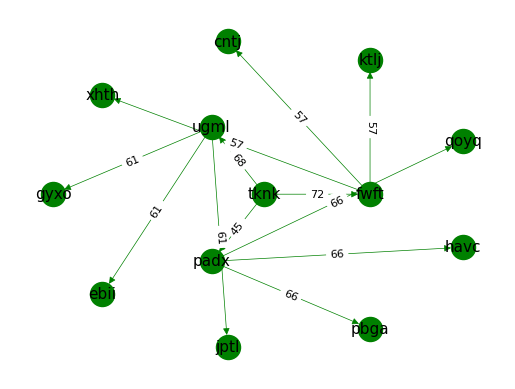

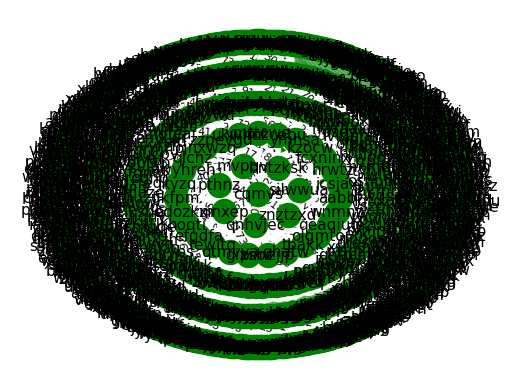

21:52:42.982:aoc2017 - INF: Part 1 soln=cqmvs


CPU times: total: 5.25 s
Wall time: 11.2 s


In [249]:
%%time
sample_data = [
    "pbga (66)",
    "xhth (57)",
    "ebii (61)",
    "havc (66)",
    "ktlj (57)",
    "fwft (72) -> ktlj, cntj, xhth",
    "qoyq (66)",
    "padx (45) -> pbga, havc, qoyq",
    "tknk (41) -> ugml, padx, fwft",
    "jptl (61)",
    "ugml (68) -> gyxo, ebii, jptl",
    "gyxo (61)",
    "cntj (57)"
]

sample_solution = part1(sample_data)
validate(sample_solution[0], "tknk") # test with sample data
soln = part1(input_data)
logger.info(f"Part 1 soln={soln[0]}")

### Day 7 Part 2

Sad times. It looks like I can't avoid the recursion!

We're told that each path to a leaf needs to have the same weight. One of the paths will have a different weight, which means we need to adjust the weight of one of the programs.

**Given that exactly one program is the wrong weight, what would its weight need to be to balance the entire tower?**

Solution:

- Create a recursive function that calculates the total weight from a given node. It works by adding the weight of this node to the recursive weight of all children.
- That would be sufficient if we only needed the weight of the entire tower. But we need to determine the first tower that is out of balance, and to do this, we need to calculate the total weight at each level.  To do this, use a defaultdict(list) to store a list of (name, recursive weight) for each first-level child at this level.
- Then we need to determine if any of these first-level weights are different. We're told that if any weight is different from the others at this level, then this tower is out of balance. Furthermore, the first level that is out of balance on the way back will be out of balance as a result of one program in that particular tower.
- So, for the inbalanced tower, determine the two weights: the weight of the outlier, and the correct weight.
- Determine which child program corresponds to the recursive outlier weight.
- Determine the difference between correct weight and outlier weight, and add this to the weight of our identified child node. This gives us our new required weight.
- Return the new required weight; and, once we've found the required weight, simply return it all the way up the recursion stack.

In [252]:
def part2(progs: dict[str, Prog], node_name: str, level: int = 0, stop_on_inbalance=True) -> tuple[int, int]:
    """ Determines the recursive total weight for this program and all children.
    Also determine the desired new weight for the single program that is out of balance.

    Args:
        progs (dict[str, Prog]): the dict of programs.
        node_name (str): the root node we want to recurse for.
        level (int, optional): the current level, relative to original root supplied. Defaults to 0.
        stop_on_inbalance (boolean): Whether to exit the function once we identify the inbalance.
                                     Defaults to True. If false, we will complete the weight recursion.

    Returns:
        _type_: (total weight, new weight for program)
    """
    curr_node = progs[node_name]
    
    level_weights = defaultdict(list) # Dictionary to store total weights of children at each level
    
    total_weight = curr_node.weight # initialise with weight of this prog
    next_level = level+1
    for child in curr_node.children: # and now recursively add the weight of all children
        child_recursive_weight, new_weight = part2(progs, child, next_level)
        
        # if we've identified the outlier, we can quit the recursion now
        if new_weight and stop_on_inbalance: 
            return child_recursive_weight, new_weight
        
        total_weight += child_recursive_weight # the recursive weight of this child
        level_weights[next_level].append((child, child_recursive_weight))
        
    # Check if any child has a different weight
    for lvl, recursive_weights in level_weights.items(): # current lvl, list of tuples
        weight_counts: dict[int, list] = defaultdict(list) # store {weight, [name1, name2, etc]}
        for child_name, recursive_weight in recursive_weights:
            weight_counts[recursive_weight].append(child_name)
            
        if len(weight_counts) > 1:  # Different weights found, this tower is out of balance
            logger.debug(f"Level {lvl} has different weights: {recursive_weights}")
            
            # Identifier the outlier
            outlier_weight = correct_weight = 0
            outlier_name = None
            for weight, child_names in weight_counts.items():
                if len(child_names) == 1: # this is the outlier
                    outlier_weight = weight
                    outlier_name = child_names[0]
                else: # more than one name with this weight - these towers are correct
                    correct_weight = weight    
                    
            assert outlier_weight and correct_weight, "We should have determined two weights"        
            assert outlier_name, "We should have identified the program with wrong weight"
            
            logger.debug(f"Prog to change={outlier_name}; current weight={progs[outlier_name].weight}")
            
            # Calculate the new required weight for the outlier
            new_weight = progs[outlier_name].weight + (correct_weight - outlier_weight)   
            logger.debug(f"Required new weight={new_weight}")
            return total_weight, new_weight
                    
    return total_weight, 0

In [254]:
%%time
validate(part2(sample_solution[1], sample_solution[0])[1], 60) # test with sample data
weight = part2(soln[1], soln[0])[1]
logger.info(f"Part 2 soln={weight}")

22:05:33.519:aoc2017 - INF: Part 2 soln=2310


CPU times: total: 0 ns
Wall time: 2.19 ms
